# 1. Environment Setup & Libraries

In [2]:
# 1.1 Install Dependencies
!pip install -q flwr[simulation] torch torchvision torchaudio tensorflow pandas scikit-learn seaborn matplotlib

# 1.2 Import Libraries
import pandas as pd
import numpy as np
import glob
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import seaborn as sns
import matplotlib.pyplot as plt

# Federated Learning Imports
import flwr as fl
from flwr.common import Context
from flwr.client import NumPyClient
from flwr.client import ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

# Config
pd.set_option('display.max_columns', None)
print("Environment Ready.")

Environment Ready.


# 2. Data Acquisition & Sampling strategy

In [3]:
# PATH TO DATA
ruta_carpeta_processed = "data/processed/" 

# Get a list of all CSV files
all_files = glob.glob(os.path.join(ruta_carpeta_processed, "*.csv"))
print(f"Found {len(all_files)} CSV files. Processing...")

# List to store the dataframes
df_list = []

# Iterate over each file
for filename in all_files:
    try:
        # Read in chunks to manage memory
        for chunk in pd.read_csv(filename, chunksize=100000, low_memory=False):
            chunk.columns = chunk.columns.str.strip()
            
            # Identify label column
            if 'label' in chunk.columns:
                target_col = 'label'
            else:
                target_col = chunk.columns[-1]
            
            chunk[target_col] = chunk[target_col].astype(str)
            
            # --- SAMPLING STRATEGY ---
            # 1. Keep ALL Malicious (C&C) traffic
            condicion_cc = chunk[target_col].str.contains("C&C", case=False, na=False)
            df_cc = chunk[condicion_cc].copy()
            
            # 2. Keep only 5% of Benign traffic (Downsampling)
            condicion_normal = chunk[target_col].str.contains("Normal|Benign", case=False, na=False)
            df_normal = chunk[condicion_normal].sample(frac=0.05, random_state=42)
            
            # Save chunks if they contain data
            if not df_cc.empty:
                df_list.append(df_cc)
            if not df_normal.empty:
                df_list.append(df_normal)
            
    except Exception as e:
        print(f"Error reading {filename}: {e}")

# Concatenate everything
full_df = pd.concat(df_list, ignore_index=True)

print(f"Dataset loaded successfully.")
print(f"Total rows: {full_df.shape[0]}")
print("Distribution of labels:")
print(full_df['label'].value_counts())

Found 78 CSV files. Processing...
Dataset loaded successfully.
Total rows: 643803
Distribution of labels:
label
Benign                      612845
Merlin C&C Communication     29356
Mirai C&C Communication       1074
C&C Communication              528
Name: count, dtype: int64


# 3. Data Preprocessing & Feature Engineering

In [4]:
# Make a copy to avoid modifying the original dataframe
df_model = full_df.copy()

# 3.1 Binary Classification Target (0: Normal, 1: C&C)
df_model['binary_label'] = df_model['label'].apply(lambda x: 0 if 'Normal' in x or 'Benign' in x else 1)
print("Class Distribution (0=Normal, 1=C&C):")
print(df_model['binary_label'].value_counts())

# 3.2 Remove Identifiers & Leaky Features (CRITICAL STEP)
# We remove IPs and MACs so the model learns traffic patterns, not specific devices.
cols_to_drop = ['label', 'ip.src', 'ip.dst', 'eth.src', 'eth.dst', 'frame.time']
df_model = df_model.drop(columns=[c for c in cols_to_drop if c in df_model.columns], errors='ignore')

# 3.3 Encode Categorical Features
categorical_cols = df_model.select_dtypes(include=['object']).columns
print(f"Encoding categoricals: {list(categorical_cols)}")

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))

# 3.4 Feature Selection (Remove Constant Columns)
X = df_model.drop(columns=['binary_label'])
y = df_model['binary_label']

constant_columns = [col for col in X.columns if X[col].nunique() <= 1]
if constant_columns:
    print(f"Dropping constant columns: {constant_columns}")
    X = X.drop(columns=constant_columns)

# 3.5 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3.6 Scaling (Normalization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle NaNs created by scaling
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

print(f"Preprocessing Complete. Input Shape: {X_train.shape}")

Class Distribution (0=Normal, 1=C&C):
binary_label
0    612845
1     30958
Name: count, dtype: int64
Encoding categoricals: ['frame.protocols', 'ip.flags', 'ip.checksum', 'tcp.flags', 'tcp.checksum', 'tcp.options']
Dropping constant columns: ['ip.tos']
Preprocessing Complete. Input Shape: (515042, 16)


# 4. DNN - Centralized Deep Learning

## 4.1 Define Model Architecture (Keras)

In [20]:
central_model = Sequential()
central_model.add(Input(shape=(X_train.shape[1],)))
central_model.add(Dense(64, activation='relu'))
central_model.add(Dropout(0.2))
central_model.add(Dense(32, activation='relu'))
central_model.add(Dropout(0.2))
central_model.add(Dense(16, activation='relu'))
central_model.add(Dense(1, activation='sigmoid'))

central_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
central_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Training

In [21]:
print("Starting Centralized Training...")
central_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Starting Centralized Training...
Epoch 1/10


C:\Users\Andrea\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)


6439/6439 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9943 - loss: 0.0157 - val_accuracy: 0.9980 - val_loss: 0.0051
Epoch 2/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9982 - loss: 0.0046 - val_accuracy: 0.9982 - val_loss: 0.0042
Epoch 3/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 4/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9988 - loss: 0.0031 - val_accuracy: 0.9985 - val_loss: 0.0026
Epoch 5/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9991 - val_loss: 0.0020
Epoch 6/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.9995 - val_loss: 0.0016
Epoch 7/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 8/10
6439/6439 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9992 - loss: 0.0022 - val

## 4.3 Evaluation & Confusion Matrix


Final Test Accuracy (Centralized): 99.9643%
4024/4024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Classification Report (Centralized) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       0.99      1.00      1.00      6192

    accuracy                           1.00    128761
   macro avg       1.00      1.00      1.00    128761
weighted avg       1.00      1.00      1.00    128761



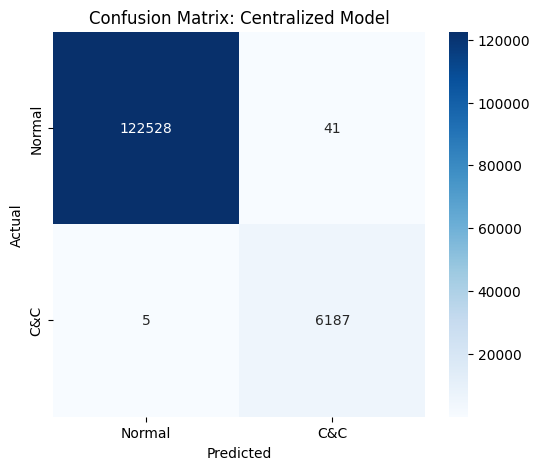

In [22]:
# 1. Evaluate on the test set
loss, accuracy = central_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy (Centralized): {accuracy*100:.4f}%")

# 2. Detailed predictions
y_pred_prob = central_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 3. Classification Report
print("\n--- Classification Report (Centralized) ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'C&C']))

# 4. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Centralized Model')
plt.show()

# 5. DNN - Federated Learning Simulation

## 5.1 Partition Data & Helper Functions

In [5]:
# Config
NUM_CLIENTS = 5
client_datasets = []
chunk_size = len(X_train) // NUM_CLIENTS

print(f"Partitioning data among {NUM_CLIENTS} clients...")

for i in range(NUM_CLIENTS):
    start = i * chunk_size
    end = (i + 1) * chunk_size
    # Convert to PyTorch Tensors
    x_chunk = torch.tensor(X_train[start:end], dtype=torch.float32)
    y_chunk = torch.tensor(y_train[start:end].values, dtype=torch.float32).unsqueeze(1)
    
    dataset = TensorDataset(x_chunk, y_chunk)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    client_datasets.append(loader)

# Define PyTorch Model (Must match Keras architecture logic)
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.sigmoid(self.fc4(x))

Partitioning data among 5 clients...


## 5.2 Define Client & Custom Strategy

In [6]:
# Define Flower Client
class IoTClient(NumPyClient):
    def __init__(self, train_loader):
        self.model = Net(input_shape=X_train.shape[1])
        self.train_loader = train_loader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        for X_batch, y_batch in self.train_loader:
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(X_batch), y_batch)
            loss.backward()
            self.optimizer.step()
        return self.get_parameters(config={}), len(self.train_loader.dataset), {}

def client_fn(context: Context):
    partition_id = int(context.node_config["partition-id"])
    return IoTClient(client_datasets[partition_id]).to_client()

class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            self.global_parameters = aggregated_parameters
        return aggregated_parameters, aggregated_metrics

## 5.3 Run Simulation

In [7]:
print("Starting Federated Learning Simulation (5 Rounds)...")

# 1. Define the ClientApp
# This function creates a new client for each simulated device
client_app = ClientApp(
    client_fn=client_fn  
)
strategy = None

# 2. Define the ServerApp
def server_fn(context: Context):
    global strategy
    # Define the custom strategy to save the global model
    strategy = SaveModelStrategy(
        fraction_fit=1.0,
        fraction_evaluate=0.0
    )
    # Server configuration (5 rounds)
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server_app = ServerApp(server_fn=server_fn)

# 3. Start the Simulation
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,  
    backend_config={"client_resources": {"num_cpus": 1, "num_gpus": 0.0}} 
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Starting Federated Learning Simulation (5 Rounds)...


C:\Users\Andrea\AppData\Local\Programs\Python\Python311\Lib\site-packages\ray\_private\worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(pid=21944) 2026-01-11 13:09:52.763799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=21944) 2026-01-11 13:09:58.847473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 12x acr

## 5.4 Global Model Reconstruction & Evaluation


Final Test Accuracy (Federated): 99.8975% 


--- Classification Report (Federated Learning) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       1.00      0.98      0.99      6192

    accuracy                           1.00    128761
   macro avg       1.00      0.99      0.99    128761
weighted avg       1.00      1.00      1.00    128761



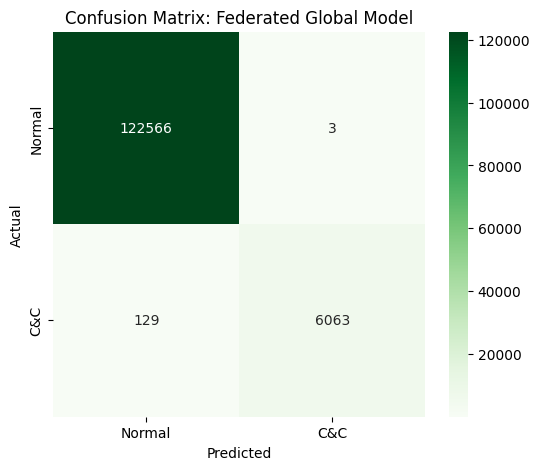

In [8]:
# 1. Retrieve the final global parameters from the strategy
parameters = fl.common.parameters_to_ndarrays(strategy.global_parameters)

# 2. Load parameters into a new PyTorch model instance
global_model = Net(input_shape=X_train.shape[1])
params_dict = zip(global_model.state_dict().keys(), parameters)
state_dict = {k: torch.tensor(v) for k, v in params_dict}
global_model.load_state_dict(state_dict, strict=True)

# 3. Prepare Test data (convert to PyTorch Tensors)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 4. Detailed predictions
global_model.eval()
with torch.no_grad():
    y_pred_prob_fl = global_model(X_test_tensor).numpy()
    
y_pred_fl = (y_pred_prob_fl > 0.5).astype(int)

exact_accuracy = accuracy_score(y_test, y_pred_fl)
print(f"\nFinal Test Accuracy (Federated): {exact_accuracy*100:.4f}% \n")

# 5. Classification Report
print("\n--- Classification Report (Federated Learning) ---")
print(classification_report(y_test, y_pred_fl, target_names=['Normal', 'C&C']))

# 6. Confusion Matrix
plt.figure(figsize=(6, 5))
cm_fl = confusion_matrix(y_test, y_pred_fl)
sns.heatmap(cm_fl, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Federated Global Model')
plt.show()

# 6. K-Nearest Neighbors

## 6.1 Importing necessary modules

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 6.2 KNN Training and Evaluation

Starting KNN Training (K=3)...
Predicting on Test set...

>>> Final Test Accuracy (KNN): 99.9596% <<<

--- Classification Report (KNN) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       1.00      1.00      1.00      6192

    accuracy                           1.00    128761
   macro avg       1.00      1.00      1.00    128761
weighted avg       1.00      1.00      1.00    128761



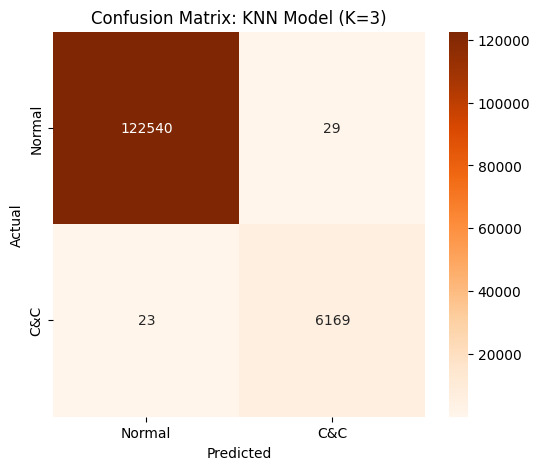

In [10]:
print("Starting KNN Training (K=3)...")

# 1. Define the model (K=3 based on reference notebook)
knn_model = KNeighborsClassifier(n_neighbors=3)

# 2. Train the model
knn_model.fit(X_train, y_train)

# 3. Predictions
print("Predicting on Test set...")
y_pred_knn = knn_model.predict(X_test)

# 4. Evaluation metrics
exact_accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\n>>> Final Test Accuracy (KNN): {exact_accuracy_knn*100:.4f}% <<<\n")

# Classification Report
print("--- Classification Report (KNN) ---")
print(classification_report(y_test, y_pred_knn, target_names=['Normal', 'C&C']))

# 5. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm_knn = confusion_matrix(y_test, y_pred_knn)
# Using 'Oranges' colormap to distinguish from DL models
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN Model (K=3)')
plt.show()

# 7. XGBoost

## 7.1 Importing necessary modules

In [14]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   --- ------------------------------------ 5.8/72.0 MB 35.3 MB/s eta 0:00:02
   -------- ------------------------------- 15.5/72.0 MB 42.2 MB/s eta 0:00:02
   ------------- -------------------------- 24.6/72.0 MB 42.2 MB/s eta 0:00:02
   ------------------ --------------------- 32.8/72.0 MB 42.4 MB/s eta 0:00:01
   ---------------------- ----------------- 41.2/72.0 MB 40.9 MB/s eta 0:00:01
   ---------------------------- ----------- 50.9/72.0 MB 42.1 MB/s eta 0:00:01
   --------------------------------- ------ 60.6/72.0 MB 42.9 MB/s eta 0:00:01
   ---------------------------------------  71.0/72.0 MB 44.0 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 39.9 MB/s  0:00:01


## 7.2 Training and Evaluation

Predicting on Test set...

>>> Final Test Accuracy (XGBoost): 100.0000% <<<

--- Classification Report (XGBoost) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       1.00      1.00      1.00      6192

    accuracy                           1.00    128761
   macro avg       1.00      1.00      1.00    128761
weighted avg       1.00      1.00      1.00    128761



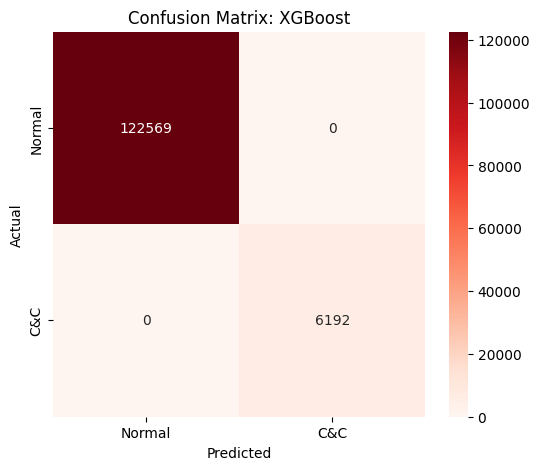

In [16]:
# 1. Define the model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# 2. Train the model
xgb_model.fit(X_train, y_train)

# 3. Predictions
print("Predicting on Test set...")
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluation metrics
exact_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n>>> Final Test Accuracy (XGBoost): {exact_accuracy_xgb*100:.4f}% <<<\n")

# Classification Report
print("--- Classification Report (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'C&C']))

# 5. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
# Using 'Reds' colormap
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost')
plt.show()

# 8. Decision Tree

## 8.1 Importing necessary modules

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## 8.2 Training and Evaluation

Predicting on Test set...

>>> Final Test Accuracy (Decision Tree): 100.0000% <<<

--- Classification Report (Decision Tree) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       1.00      1.00      1.00      6192

    accuracy                           1.00    128761
   macro avg       1.00      1.00      1.00    128761
weighted avg       1.00      1.00      1.00    128761



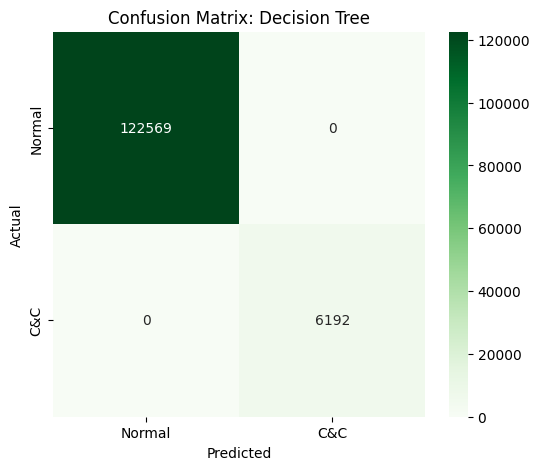

In [20]:
# 1. Define the model
dt_model = DecisionTreeClassifier(random_state=42)

# 2. Train the model
dt_model.fit(X_train, y_train)

# 3. Predictions
print("Predicting on Test set...")
y_pred_dt = dt_model.predict(X_test)

# 4. Evaluation metrics
exact_accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\n>>> Final Test Accuracy (Decision Tree): {exact_accuracy_dt*100:.4f}% <<<\n")

# Classification Report
print("--- Classification Report (Decision Tree) ---")
print(classification_report(y_test, y_pred_dt, target_names=['Normal', 'C&C']))

# 5. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Decision Tree')
plt.show()

# 9. Logistic Regression

## 9.1 Importing necessary modules

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## 9.2 Training and Evaluation 

Predicting on Test set...

>>> Final Test Accuracy (Logistic Regression): 99.5340% <<<

--- Classification Report (Logistic Regression) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       0.96      0.94      0.95      6192

    accuracy                           1.00    128761
   macro avg       0.98      0.97      0.97    128761
weighted avg       1.00      1.00      1.00    128761



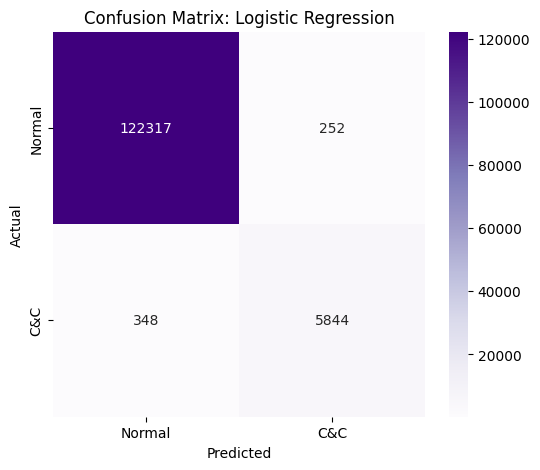

In [22]:
# 1. Define the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# 2. Train the model
lr_model.fit(X_train, y_train)

# 3. Predictions
print("Predicting on Test set...")
y_pred_lr = lr_model.predict(X_test)

# 4. Evaluation metrics
exact_accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\n>>> Final Test Accuracy (Logistic Regression): {exact_accuracy_lr*100:.4f}% <<<\n")

# Classification Report
print("--- Classification Report (Logistic Regression) ---")
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'C&C']))

# 5. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# 10. Extra Trees

## 10.1 Importing necessary modules

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## 10.2 Training and Evaluation

Predicting on Test set...

>>> Final Test Accuracy (Extra Trees): 99.9992% <<<

--- Classification Report (Extra Trees) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       1.00      1.00      1.00      6192

    accuracy                           1.00    128761
   macro avg       1.00      1.00      1.00    128761
weighted avg       1.00      1.00      1.00    128761



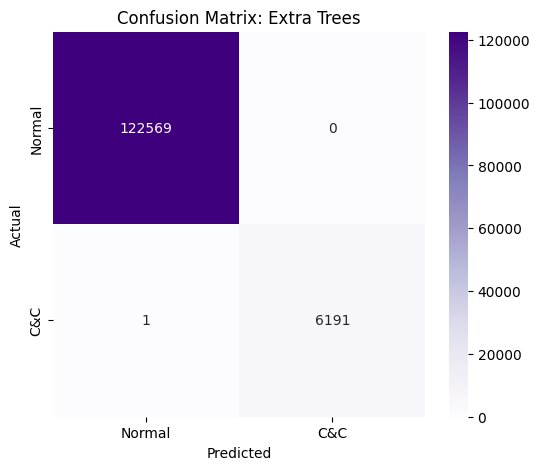

In [27]:
# 1. Define the model
et_model = ExtraTreesClassifier()

# 2. Train the model
et_model.fit(X_train, y_train)

# 3. Predictions
print("Predicting on Test set...")
y_pred_et = et_model.predict(X_test)

# 4. Evaluation metrics
exact_accuracy_et = accuracy_score(y_test, y_pred_et)
print(f"\n>>> Final Test Accuracy (Extra Trees): {exact_accuracy_et*100:.4f}% <<<\n")

# Classification Report
print("--- Classification Report (Extra Trees) ---")
print(classification_report(y_test, y_pred_et, target_names=['Normal', 'C&C']))

# 5. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm_et = confusion_matrix(y_test, y_pred_et)
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Purples', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Extra Trees')
plt.show()

# 11. Random Forest

## 11.1 Importing necessary modules

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## 11.2 Training and Evaluation

Predicting on Test set...

>>> Final Test Accuracy (Random Forest): 100.0000% <<<

--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    122569
         C&C       1.00      1.00      1.00      6192

    accuracy                           1.00    128761
   macro avg       1.00      1.00      1.00    128761
weighted avg       1.00      1.00      1.00    128761



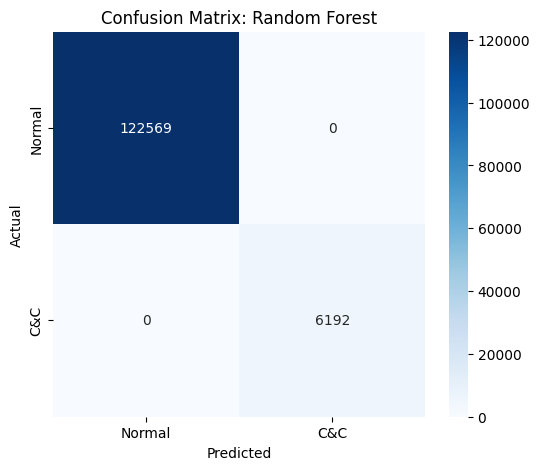

In [31]:
# 1. Define the model 
rf_model = RandomForestClassifier(
    n_estimators=70,        
    max_depth=20,           
    max_features='sqrt',    
    class_weight='balanced',
    random_state=42         
)

# 2. Train the model
rf_model.fit(X_train, y_train)

# 3. Predictions
print("Predicting on Test set...")
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluation metrics
exact_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n>>> Final Test Accuracy (Random Forest): {exact_accuracy_rf*100:.4f}% <<<\n")

# Classification Report
print("--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'C&C']))

# 5. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'C&C'], yticklabels=['Normal', 'C&C'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest')
plt.show()